# Final Project: Wrangling and Analyzing Twitter Data
## Table of Contents
<ul>
<li><a href="#Gather">Data Gathering</a></li>
<li><a href="#Assess">Data Assessing</a></li>
<li><a href="#Clean">Data Cleaning</a></li>  
<li><a href="#A">Analyzing and Visualizing Data</a></li>    
</ul>

In [879]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import json
import tweepy
import operator

<a id='Gather'></a>
## Data Gathering:

### 1st Download the Image Predictions File and read it:

In [880]:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', auth=('user', 'pass'))
r.status_code

200

In [881]:
image_pre = pd.read_csv("image-predictions.tsv", sep = '\t')

### 2nd Read the CSV file:

In [882]:
TArchive = pd.read_csv("twitter-archive-enhanced.csv")


### 3rd gather data by Twitter Api:

In [883]:
#Api_Key = 'Secret'
#Api_Secret = 'Secret'
#access_token = 'Secret'
#access_secret = 'Secret'

#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth)

In [884]:
#tweet_ids = df.tweet_id.values
#tweet_ids

In [885]:
'''
count = 0
fails_dict = {}
start = timer()
with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''
print("")

In [886]:
tweet_json = pd.read_json('tweet.json', lines=True)

<a id='Assess'></a>
## Assessing Data:
<ul>
<li><a href="#V">Visual assessment</a></li>
<li><a href="#P">Programmatic assessment</a></li>
</ul>

<a id='V'></a>
### Visual assessment:

> i used code in Visual assessment as it is more easy to show the parts i found issues in instead of sharing pictures although i did find these issues by looking through the data 

In [887]:
TArchive[["timestamp"]].sample(5)

,timestamp
753,2016-09-22 01:54:34 +0000
1798,2015-12-16 20:48:40 +0000
562,2016-11-26 19:50:26 +0000
2074,2015-11-29 05:52:33 +0000
2211,2015-11-23 02:19:29 +0000


> As you can see in the Column Above named "timestamp" in the end of every row there is a strange formula which is +0000 which i find it's not important and this is a quality issue

In [888]:
TArchive[(TArchive.rating_numerator < 10) | (TArchive.rating_numerator > 20)][["rating_numerator"]].sample(5)

,rating_numerator
845,9
1799,9
1912,8
2056,9
516,24


>There are some rows that contains numerators higher than 20 and others with lower than 10 which may seem impossible according the scale of the WeRateDogs twitter account, "The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10" so i think they are either outliers or they are miswrittern and the sum of the rows with this issue are 440

In [889]:
TArchive[TArchive.rating_denominator != 10][["rating_denominator"]].sample(3)

,rating_denominator
1662,11
1779,120
1663,16


> The same as the above issue the denominator can't be any number other than 10 because These ratings almost always have a denominator of 10 according to WeRateDogs the sum of the rows with this issue are 23

In [890]:
TArchive[TArchive.name.str.len() == 1][["name"]].sample(5)

,name
2348,a
1499,a
2222,a
2353,a
1955,a


>some dog names contain only one letter which is not possible and number of rows with this issue is 56

In [891]:
TArchive[["doggo", "floofer", "pupper", "puppo"]].sample(5)

,doggo,floofer,pupper,puppo
2139,None,None,None,None
549,None,None,None,None
2026,None,None,None,None
1259,None,None,None,None
499,doggo,None,None,None


>these 4 columns can be joined into 1 column which can be named dog type which may appear to be better and this is a Tidiness issue 

In [892]:
TArchive[["rating_numerator", "rating_denominator"]].sample(5)

,rating_numerator,rating_denominator
1358,12,10
1563,10,10
166,12,10
104,13,10
371,12,10


>the same issue as the above the 2 ratings columns can be joined into 1 column named Dog Rate

In [893]:
TArchive[["timestamp"]].sample(3)

,timestamp
1606,2016-01-09 03:40:16 +0000
1294,2016-03-10 18:25:30 +0000
1298,2016-03-10 01:35:01 +0000


> in this column the opposite may occur each column contains both a date and time in hours so it will be better to split each column into 2 other columns holding the names "Date", and "time" to avoid confusion

In [894]:
TArchive[TArchive.name == "None"][["name"]].sample(3)

,name
1810,None
1102,None
494,None


> some dog names are written "None" it would be better to change these factors to nulls because the computer will read them as dog names not nulls although they are orginally nulls

In [895]:
TArchive[TArchive.retweeted_status_id.notnull()][["retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"]].sample(5)

,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp
250,7.733088e+17,4.196984e+09,2016-09-06 23:56:05 +0000
615,7.809316e+17,4.196984e+09,2016-09-28 00:46:20 +0000
386,8.099208e+17,4.196984e+09,2016-12-17 00:38:52 +0000
431,8.192277e+17,4.196984e+09,2017-01-11 17:01:16 +0000
455,8.164506e+17,4.196984e+09,2017-01-04 01:05:59 +0000


> it appears from above that these rows are the retweets so we must remove them as demanded by the project 

<a id='P'></a>
### Programmatic assessment:

In [896]:
TArchive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

><li>From above we can conclude that there is so much missing data and aside from the data named none in some columns</li>
><li>the "tweet_id" column dtype id int64 which is wrong for ids because you can't do algebric equations on them so it must be an object dtype</li>

In [897]:
TArchive.tweet_id.duplicated().sum()

0

> it seems there is no duplicated rows and we can make sure by that according that there is no duplicated tweet_ids

In [898]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

>the id column seems to be duplicated so i will only keep one, otherwise this data isn't important to be cleaned as i will only gather the data i want from it which i will do next

In [899]:
image_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [900]:
image_pre.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1979,870804317367881728,https://pbs.twimg.com/media/DBW35ZsVoAEWZUU.jpg,1,home_theater,0.168290,False,sandbar,0.098040,False,television,0.079729,False
551,677557565589463040,https://pbs.twimg.com/media/CWcrAVQWEAA6QMp.jpg,1,seat_belt,0.277257,False,Shih-Tzu,0.249017,True,Pekinese,0.209213,True
954,705223444686888960,https://pbs.twimg.com/media/Ccl0-HVVAAAf8aK.jpg,1,Egyptian_cat,0.090508,False,Chesapeake_Bay_retriever,0.077373,True,Mexican_hairless,0.049471,True


> this data is already cleaned

## Quality Issues
1. timestamp column contains +0000 at their ends
2. The rating denominator is not always 10 as it should be 
3. the rating numerator have outliers as the range must be from 10 to 20 but it appears there were numbers above 20 and others lower than 10
4. some dog names contains only letters such as "a" or "O" which can't be a dog name
5. The source, in_reply_to_status_id, and in_reply_to_user_id columns doesn't contain any important information
6. tweet_id dtype is integer which is wrong it must be object
7. retweets are included in the database and they must be removed 
8.  we can remove all three columns related to the retweets as we won't use them after we distinguish the retweeted rows and delete them.
9. There is some missing data in some columns

## Tidiness Issues
1. The columns named "doggo", "floofer", "pupper", and "puppo" can all be joined into 1 column 
2. The rating_denominator and rating_numerator column can both be joined into 1 column
3. the column time_stamp can be split into 2 columns to avoid confusion
4. In dog name's column missing data is labled by "None" which is wrong as the computer reads it as a data and not nulls
5. Tweets beyond  August 1st, 2017 are not needed as demanded from the project because the algorithm won't work on them
6. some columns i want from tweet_json file into the tweet archive file so i can analyaze on only 1 file

## Cleaning Data:

### Data Copying:

In [901]:
TArchive_copy = TArchive.copy()
Image_pre_copy = Image_pre.copy()
tweet_json_copy = tweet_json.copy()

### Issue 1: timestamp column contain +0000 in there ends

#### Define: in the last of each timestamp element there is a stange form  "+0000" which is not neccassary so i will remove it

#### Code

In [902]:
TArchive_copy.timestamp = TArchive_copy.timestamp.str[:-6]

#### Test

In [903]:
TArchive_copy[["timestamp"]].sample(3)

,timestamp
1947,2015-12-07 03:07:12
910,2016-07-25 16:21:11
949,2016-07-11 01:11:51


### Issue 2: The rating denominator is not always 10 as it should be

#### Define: the rating denominator should always be 10 otherwise it's an invalidation to the unique rating system

#### Code

In [904]:
TArchive_copy.rating_denominator = 10

#### Test

In [905]:
TArchive_copy[TArchive_copy.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [906]:
TArchive_copy[["rating_denominator"]].sample()

,rating_denominator
1937,10


### Issue 3: The rating numerator outliers

#### Define: at first sight i though that these number were wrong numbers but it appeared that these ratings are normal and were written in the Tweet itself i tried to solve this problem for so much time but in the end i discovered it's not a problem from the beginning.

#### Code

In [907]:
TArchive.iloc[[188, 290, 1662]][["text", "rating_numerator"]]

,text,rating_numerator
188,@dhmontgomery We also gave snoop dogg a 420/10...,420
290,@markhoppus 182/10,182
1662,This is Darrel. He just robbed a 7/11 and is i...,7


> you can see from the above example the rating numerator is the same as the written one in the tweet so it's not an issue

### Issue 4: Wrong dog names

#### Define: it seems that i can't gather the names of these dogs as they are not either avalaible in the tweet or any other table so i will only turn them to nulls

#### Code

In [908]:
TArchive_copy["name"].replace(to_replace= "O", value= np.nan, inplace= True)
TArchive_copy["name"].replace(to_replace= "a", value= np.nan, inplace= True)

#### Test

In [909]:
TArchive_copy[TArchive_copy.name.str.len() == 1].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Issue 5: Columns deletion

#### Define: The source, in_reply_to_status_id, and in_reply_to_user_id columns doesn't contain any important information

#### Code

In [910]:
def delete_columns(column_name):
    del TArchive_copy[column_name]
    
try:
    delete_columns('source')
    delete_columns('in_reply_to_status_id')
    delete_columns('in_reply_to_user_id')
except:
    print("already deleted")

In [911]:
for col in TArchive_copy.columns:
    print(col)

tweet_id
timestamp
text
retweeted_status_id
retweeted_status_user_id
retweeted_status_timestamp
expanded_urls
rating_numerator
rating_denominator
name
doggo
floofer
pupper
puppo


#### Test

### Issue 6: tweet_id dtype

#### Define: the "tweet_id" column dtype id int64 which is wrong for ids because you can't do algebric equations on them so it must be an object dtype

#### Code

In [912]:
TArchive_copy.tweet_id = TArchive_copy.tweet_id.astype('object')

#### Test

In [913]:
TArchive_copy.tweet_id.dtype

dtype('O')

### Issue 7: Remove Retweets

#### Define: i detected from tweeter that if retweeted_status_id column is not a null for a certain tweet that means that it isn't a tweet but a retweet so i removed all the rows that have values for this column as they are retweets not tweets

#### Code

In [914]:
try:
    TArchive_copy = TArchive_copy[TArchive_copy.retweeted_status_id.isnull()]
except:
    print("already done")

#### Test

In [915]:
TArchive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   object 
 1   timestamp                   2175 non-null   object 
 2   text                        2175 non-null   object 
 3   retweeted_status_id         0 non-null      float64
 4   retweeted_status_user_id    0 non-null      float64
 5   retweeted_status_timestamp  0 non-null      object 
 6   expanded_urls               2117 non-null   object 
 7   rating_numerator            2175 non-null   int64  
 8   rating_denominator          2175 non-null   int64  
 9   name                        2119 non-null   object 
 10  doggo                       2175 non-null   object 
 11  floofer                     2175 non-null   object 
 12  pupper                      2175 non-null   object 
 13  puppo                       2175 

### Issue 8: Remove all three columns related to retweets

#### Define: after i deleted the retweets by using these columns there is no more need for them so i deleted them

#### Code

In [916]:
try:
    delete_columns('retweeted_status_id')
    delete_columns('retweeted_status_user_id')
    delete_columns('retweeted_status_timestamp')
except:
    print("already deleted")

#### Test

In [917]:
TArchive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   object
 1   timestamp           2175 non-null   object
 2   text                2175 non-null   object
 3   expanded_urls       2117 non-null   object
 4   rating_numerator    2175 non-null   int64 
 5   rating_denominator  2175 non-null   int64 
 6   name                2119 non-null   object
 7   doggo               2175 non-null   object
 8   floofer             2175 non-null   object
 9   pupper              2175 non-null   object
 10  puppo               2175 non-null   object
dtypes: int64(2), object(9)
memory usage: 203.9+ KB


### Issue 9:  Missing data labled "None"

#### Define: I though if we replaced the None values in the names with Nan it would be better to clean it to avoid the confusion because the computer sees them as non null values and also the data in the dog types columns i raplced it with empty space so i can merge them as in the next step and afterwords i will replace the empty with null value

#### Code

In [918]:
def replace_None(column_name, replace, value):
    TArchive_copy[column_name].replace(to_replace= replace, value= value, inplace= True)
    
try:
    replace_None("name", "None", np.nan)
    replace_None("puppo", "None", "")
    replace_None("pupper", "None", "")
    replace_None("floofer", "None", "")
    replace_None("doggo", "None", "")
except:
    print("already done")

#### Test

In [919]:
TArchive_copy[TArchive_copy.name == "None"].head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [920]:
try:
    TArchive_copy[["doggo", "floofer", "pupper", "puppo"]].sample(5)
except:
    print("columns deleted")

### Issue 10: joining 4 Columns to a column named "dog_type"

#### Define: i will join these 4 columns into 1 column which can be named dog_type which may appear to be better and this is a Tidiness issue 

#### Code

In [921]:
try:
    TArchive_copy["dog_type"] = TArchive_copy['doggo'] +""+ TArchive_copy["floofer"] +""+ TArchive_copy["pupper"] +""+ TArchive_copy["puppo"]
    delete_columns('doggo')
    delete_columns('floofer')
    delete_columns('pupper')
    delete_columns('puppo')
except:
    print("already done")
    
replace_None("dog_type", "", np.nan)

#### Test

In [922]:
TArchive_copy.sample(2)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type
2239,667937095915278337,2015-11-21 05:26:27,This dog resembles a baked potato. Bed looks u...,https://twitter.com/dog_rates/status/667937095...,3,10,NaN,NaN
449,819004803107983360,2017-01-11 02:15:36,This is Bo. He was a very good First Doggo. 14...,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo


### Issue 11: joining the denominator and numerator columns into one

#### Define: the same issue as the above the 2 ratings columns can be joined into 1 column named Dog Rate

#### Code

In [923]:
try:
    TArchive_copy["Rating"] = TArchive_copy['rating_numerator'].astype(str) +"/"+ TArchive_copy["rating_denominator"].astype(str)
    delete_columns('rating_numerator')
    delete_columns('rating_denominator')
except:
    print("already done")

#### Test

In [924]:
TArchive_copy.sample(2)

,tweet_id,timestamp,text,expanded_urls,name,dog_type,Rating
463,817423860136083457,2017-01-06 17:33:29,This is Ken. His cheeks are magic. 13/10 (IG: ...,https://twitter.com/dog_rates/status/817423860...,Ken,NaN,13/10
999,748220828303695873,2016-06-29 18:25:21,Stop what you're doing and watch this heckin m...,https://vine.co/v/iiLjKuYJpr6,NaN,NaN,13/10


### Issue 12: Splitting the time_stamp column

#### Define:  in this column the opposite may occur each column contains both a date and time in hours so it will be better to split each column into 2 other columns holding the names "Date", and "time" to avoid confusion and i will also reorder the column's order

#### Code

In [925]:
try:
    TArchive_copy[['Date', 'Time']] = TArchive_copy.timestamp.str.split(" ", expand = True)
    del TArchive_copy['timestamp']
except:
    print("already done")
TArchive_copy = TArchive_copy.loc[:, ["tweet_id","Date","Time", "text","expanded_urls", "name", "dog_type", "Rating"]]
TArchive_copy['Date']= pd.to_datetime(TArchive_copy['Date'])

#### Test

In [926]:
TArchive_copy.sample(3)

,tweet_id,Date,Time,text,expanded_urls,name,dog_type,Rating
1939,673887867907739649,2015-12-07,15:32:42,When you're having a great time sleeping and y...,https://twitter.com/dog_rates/status/673887867...,NaN,NaN,10/10
640,793241302385262592,2016-11-01,00:00:38,This is Tucker. He's out here bustin h*ckin gh...,https://twitter.com/dog_rates/status/793241302...,Tucker,NaN,13/10
593,798925684722855936,2016-11-16,16:28:21,This is Shadow. He's a firm believer that they...,https://twitter.com/dog_rates/status/798925684...,Shadow,NaN,11/10


In [927]:
TArchive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tweet_id       2175 non-null   object        
 1   Date           2175 non-null   datetime64[ns]
 2   Time           2175 non-null   object        
 3   text           2175 non-null   object        
 4   expanded_urls  2117 non-null   object        
 5   name           1439 non-null   object        
 6   dog_type       344 non-null    object        
 7   Rating         2175 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 152.9+ KB


### Issue 13: Remove tweets beyond august 1st, 2017

#### Define: this issue was requested by the project because the algorathim

#### Code

In [928]:
TArchive_copy = TArchive_copy[TArchive_copy.Date < '2017-08-01']

#### Test

In [929]:
TArchive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 2 to 2355
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tweet_id       2173 non-null   object        
 1   Date           2173 non-null   datetime64[ns]
 2   Time           2173 non-null   object        
 3   text           2173 non-null   object        
 4   expanded_urls  2115 non-null   object        
 5   name           1437 non-null   object        
 6   dog_type       344 non-null    object        
 7   Rating         2173 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 152.8+ KB


### Issue 14: Delete one of the id rows and change the dtype in twitter_json table

#### Define: i will delete one of the columns as only one is needed

#### Code

In [930]:
tweet_json_copy.id = tweet_json_copy.id.astype('object')
try:
    del tweet_json_copy["id_str"]
except:
    print("already deleted")

#### Test

In [931]:
tweet_json_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   object             
 2   full_text                      2354 non-null   object             
 3   truncated                      2354 non-null   bool               
 4   display_text_range             2354 non-null   object             
 5   entities                       2354 non-null   object             
 6   extended_entities              2073 non-null   object             
 7   source                         2354 non-null   object             
 8   in_reply_to_status_id          78 non-null     float64            
 9   in_reply_to_status_id_str      78 non-null     float64            
 10  in_reply_to_user_id     

### Issue 15: Joining some columns

#### Code

In [932]:
tweet_json_copy = tweet_json_copy[tweet_json_copy.retweeted == False]

In [933]:
TArchive_copy = pd.concat([TArchive_copy, tweet_json_copy[["favorited",  "favorite_count"]]], axis=1)
#Warning: Run one time 

In [934]:
TArchive_copy = TArchive_copy[TArchive_copy.tweet_id.notnull()]

#### Test

In [935]:
TArchive_copy.sample(3)

,tweet_id,Date,Time,text,expanded_urls,name,dog_type,Rating,favorited,favorite_count
1329,705898680587526145,2016-03-04,23:32:15,Meet Max. He's a Fallopian Cephalopuff. Eyes a...,https://twitter.com/dog_rates/status/705898680...,Max,NaN,10/10,False,3475.0
256,843981021012017153,2017-03-21,00:22:10,HE WAS DOING A SNOOZE NO SHAME IN A SNOOZE 13/...,https://twitter.com/brianstack153/status/79679...,NaN,NaN,13/10,False,23211.0
2236,668154635664932864,2015-11-21,19:50:53,Fun dogs here. Top one clearly an athlete. Bot...,https://twitter.com/dog_rates/status/668154635...,NaN,NaN,9/10,False,709.0


In [936]:
TArchive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 2 to 2355
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        2173 non-null   object        
 1   Date            2173 non-null   datetime64[ns]
 2   Time            2173 non-null   object        
 3   text            2173 non-null   object        
 4   expanded_urls   2115 non-null   object        
 5   name            1437 non-null   object        
 6   dog_type        344 non-null    object        
 7   Rating          2173 non-null   object        
 8   favorited       2171 non-null   object        
 9   favorite_count  2171 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 186.7+ KB


## Storing Data

In [937]:
TArchive_copy.to_csv('twitter_archive_master.csv', index=False)

In [938]:
new_TArchive = pd.read_csv("twitter_archive_master.csv")

<a id='A'></a>
## Analyzing and Visualizing Data:
><li><a href="#Q1">Insight 1</a></li>
><li><a href="#Q2">Insight 2</a></li>
><li><a href="#Q3">Insight 3</a></li>
><li><a href="#Q4">Visuals</a></li>

<a id='Q1'></a>
### Insight 1: Dog's Predictions by the Algorithm

In [939]:
p1 = image_pre[(image_pre['p1_dog'] == True) ].index.tolist()
p2 = image_pre[(image_pre['p2_dog'] == True) ].index.tolist()
p3 = image_pre[(image_pre['p3_dog'] == True) ].index.tolist()
dog_types = []

def func(list_name, column):
    for x in list_name:
        dog_types.append(image_pre.at[x, column])
                      
func(p1, "p1")
func(p2, "p2")
func(p3, "p3")
set1 = set(dog_types)

In [940]:
count_list = []
for i in set1:
    count = operator.countOf(dog_types, i)
    count_list.append(count)
Dogs_df = pd.DataFrame({'Type':list(set1),'Count':count_list})
Dogs_df  = Dogs_df.sort_values("Count", ascending= False)

Text(0.5, 1.0, "Dog's Predictions by the Algorithm")

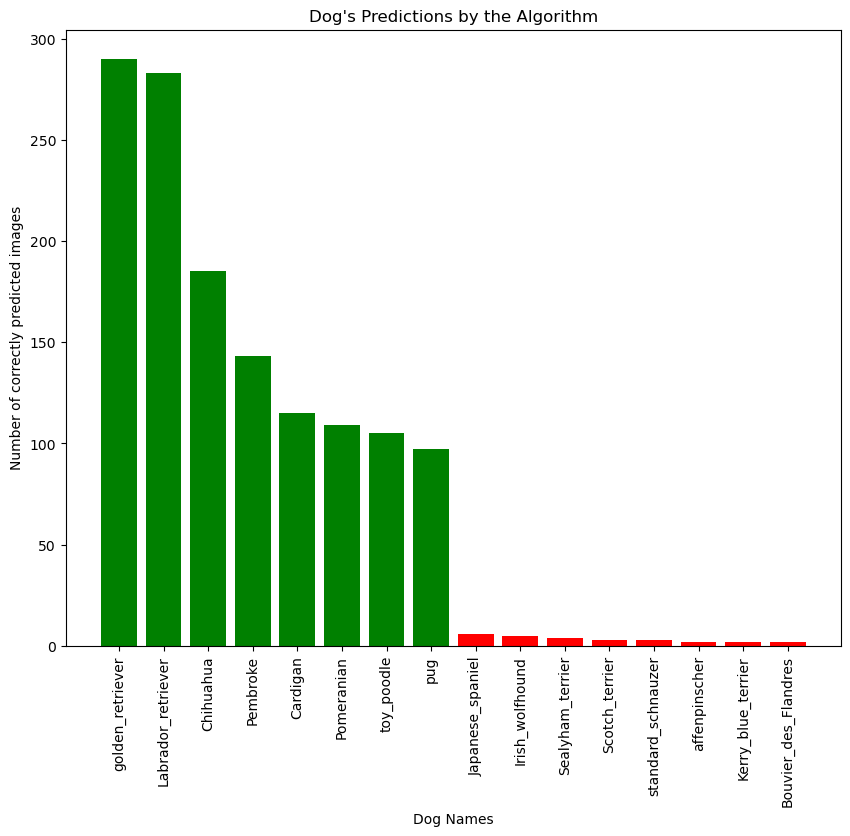

In [941]:
plt.figure(figsize=(10,8))
plt.bar(Dogs_df.Type.iloc[:8], Dogs_df.Count.iloc[:8], color=['green'])
plt.bar(Dogs_df.Type.iloc[-8:], Dogs_df.Count.iloc[-8:], color=['red'])
plt.xticks(rotation='vertical')
plt.ylabel("Number of correctly predicted images")
plt.xlabel("Dog Names")
plt.title("Dog's Predictions by the Algorithm")

> We can see from the graph above contains the highest correct times the algorithm predicted the dog type correctyly and the lowest times the algorithm predicted correctly, in the above graph the dog types that the algorithm predicts correctly it seems that the golden retriever is the easiest for the algorithm to predict and the hardest to predict is the bouvier des flandres, so we can provide more photos of the bouvier des flandres dog breed to the algorithm until it get them right and same goes for the dog breeds which have a low succcess rate

<a id='Q2'></a>
### Insight 2: Favoraited Counts in every Month

Text(0.5, 1.0, 'Favoraited Counts in every Month')

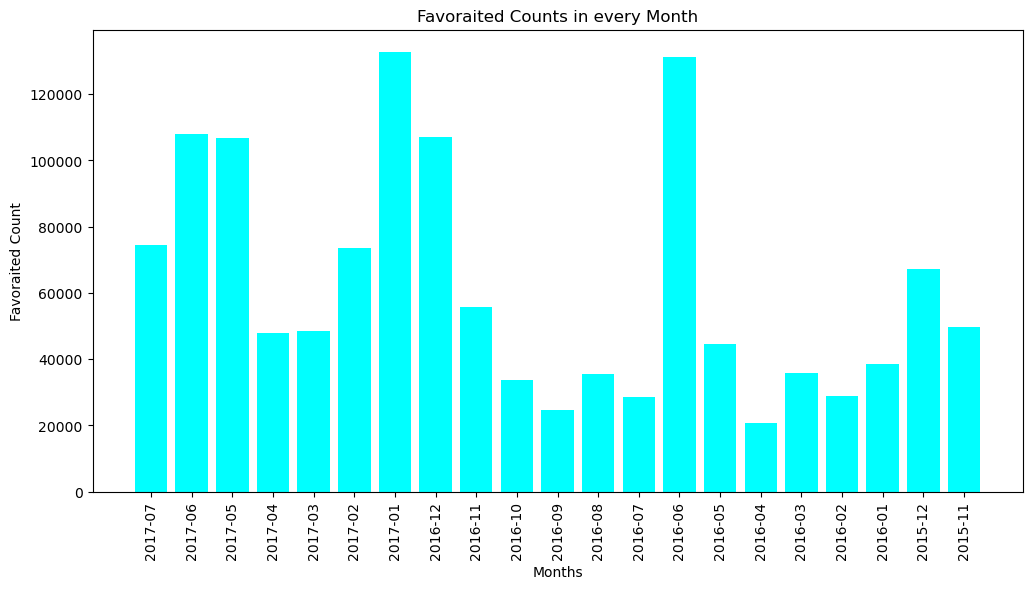

In [942]:
plt.figure(figsize=(12,6))
plt.bar(new_TArchive.Date.str[:7], new_TArchive.favorite_count, color='cyan')
plt.xticks(rotation='vertical')
plt.ylabel("Favoraited Count")
plt.xlabel("Months")
plt.title("Favoraited Counts in every Month")

> the graph above represents the number of favairotes on tweets for every month in the 3 years 2015, 2016, 2017 although not all months is appearing beacuse of the data, more importantly we can detect from this graph that in every year there are 2 months when the favairote counts increase so much which is in both december and june, i think it's related to vacations because at the end of the year there is a vacation and when working people sit home they usaully use there phones so they will interact more with socail media, that may be a weak reason but that's the only thought i can gather about this

<a id='Q3'></a>
### Insight 3: is there a correlation between the rating of the dogs and the number of people who fav the tweet?

In [943]:
try:
    fav_rat = new_TArchive[["Rating", "favorite_count"]]
    fav_rat[['N', 'D']] = fav_rat.Rating.str.split("/", expand = True)
    del fav_rat['Rating']
except:
    print("already done")

C:\Users\omarz\AppData\Local\Temp\ipykernel_13016\141299636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fav_rat[['N', 'D']] = fav_rat.Rating.str.split("/", expand = True)
C:\Users\omarz\AppData\Local\Temp\ipykernel_13016\141299636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fav_rat[['N', 'D']] = fav_rat.Rating.str.split("/", expand = True)


Text(0.5, 1.0, 'The correlation between Fav_Count and Fav_Count')

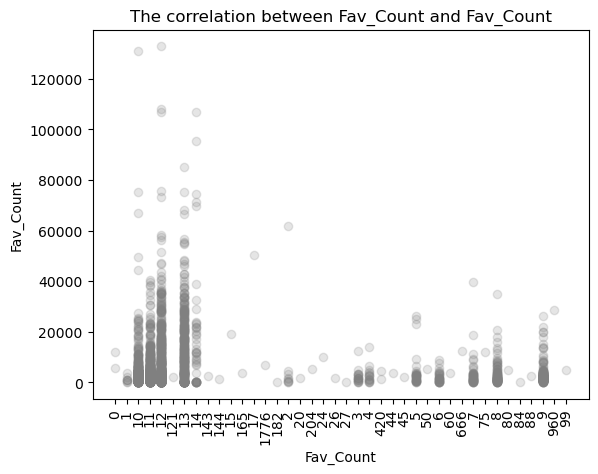

In [944]:
fav_rat = fav_rat.sort_values("N", ascending = True)
plt.scatter(fav_rat.N, fav_rat.favorite_count, alpha = 0.2, color = "grey")
plt.xticks(rotation='vertical')
plt.ylabel("Fav_Count")
plt.xlabel("Fav_Count")
plt.title("The correlation between Fav_Count and Fav_Count")

> it doesn't seem there is any correaltion between the rating given and the number of favorites on the tweet

<a id='Q3'></a>
### Visualization: Model's efficiency

In [945]:
sum1 = len(image_pre[image_pre.p1_dog == True]) + len(image_pre[image_pre.p2_dog == True]) + len(image_pre[image_pre.p3_dog == True])
sum2 = len(image_pre[image_pre.p1_dog == False]) + len(image_pre[image_pre.p2_dog == False]) + len(image_pre[image_pre.p3_dog == False])

<BarContainer object of 1 artists>

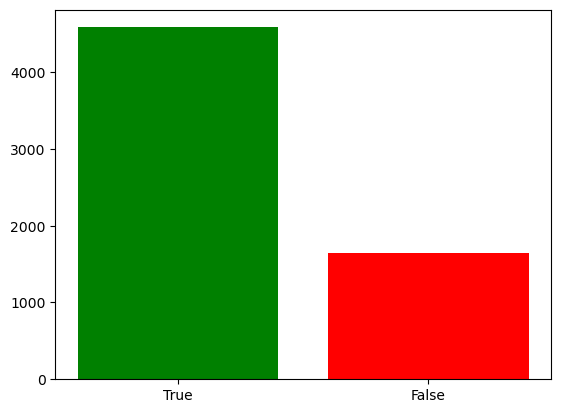

In [946]:
plt.bar("True", sum1, color = "green")
plt.bar("False", sum2, color = "red")

> it seems that the model works pretty good he got more than half the answers right

# Refrences:
<r>https://stackoverflow.com/</r>
<br>https://github.com/</br>
<r>https://www.tutorialspoint.com/\</r>
<br>https://learn.udacity.com/</br>
<r>https://www.geeksforgeeks.org/</r>
<br>https://realpython.com/</br>
<r>https://matplotlib.org//</r>
<br>https://www.w3schools.com/</br>
<r>https://www.imdb.com/interfaces/</r>